In [1]:
import modin.pandas as pd; import ray; ray.init()
import numpy as np
import random
from sklearn.model_selection import train_test_split
import chess

PATH = 'data/chessData.csv'
random.seed(0)

2023-06-03 10:08:24,024	INFO worker.py:1622 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


In [2]:
df = pd.read_csv(PATH, encoding="utf-8")
# 100000 datapoints. White's turn. Preprocess to remove "mate in X" evaluations with '#' character. All values between -2k and 2k centipawns. No 0-evaluation.
df['Evaluation'] = df['Evaluation'].apply(pd.to_numeric, errors='coerce')
df = df[(-2000 <= df['Evaluation']) & (df['Evaluation'] <= 2000) & (df['Evaluation'] != 0) & (df['FEN'].apply(lambda fen: fen.split()[1]) == 'w')].dropna()[:100000]

2023-06-03 10:08:25,944	WARNING __init__.py:183 -- DeprecationWarning: `ray.worker.global_worker` is a private attribute and access will be removed in a future Ray version.
This function is deprecated and will be removed by Ray 2.4. Please use Runtime Environments https://docs.ray.io/en/releases-2.4.0/ray-core/handling-dependencies.html to manage dependencies in workers.


Text(0.5, 0, 'Evaluation Score (Centipawns)')

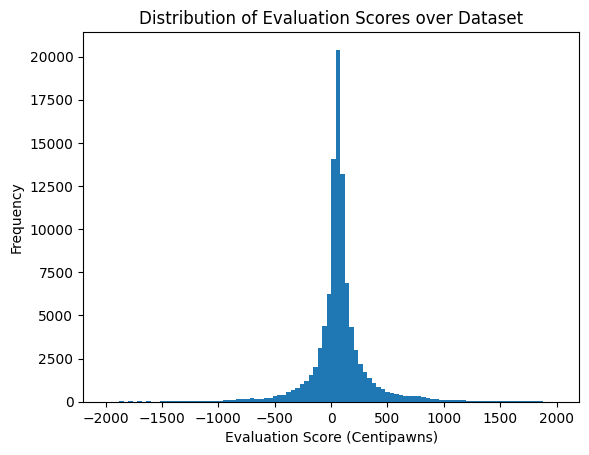

In [3]:
y = df['Evaluation']
fig = y.plot.hist(bins=100)
fig.set_title('Distribution of Evaluation Scores over Dataset')
fig.set_xlabel('Evaluation Score (Centipawns)')

In [4]:
### 80/10/10 train/val/test split
df_train, df_test  = train_test_split(df, test_size=0.2, random_state=1)
df_val, df_test= train_test_split(df_test, test_size=0.5, random_state=1)
print('Train/Validation/Test Splits: ' , df_train.shape[0], df_val.shape[0], df_test.shape[0])

Train/Validation/Test Splits:  80000 10000 10000


In [5]:
"""
Credits to @shailesh for portions of this code.
https://github.com/ShaileshSridhar2403/neuralStockfish
"""
pieces = (chess.PAWN,chess.KNIGHT,chess.BISHOP,chess.ROOK,chess.QUEEN,chess.KING)
colours = (chess.WHITE,chess.BLACK)

def fenToVec(fen):
	"""
	Input: 
	FEN string.
	
	Output: 768-vector. Each of the 12 sets (where each set is one of the unique pieces) 
	of 64 elements (where each element is a square) is a one-hot encoding of whether the
	piece is on the square. 12 * 64 = 768.
	"""
	posFen = fen.split()[0]
	board = chess.BaseBoard(posFen)
	l = []
	
	for colour in colours:
		for piece in pieces:
			v = np.zeros(64)
			for i in board.pieces(piece,colour):
				v[i] = 1
			l.append(v)
	l = np.concatenate(l)
	return l


def vecToFen(vec):
	"""
	Reverses above function.
	"""
	vecList = np.split(vec,12)
	whiteList = vecList[:6]
	blackList = vecList[6:]
	board = chess.BaseBoard()
	board.clear_board()
	for pieceType in range(len(whiteList)):
		pieceArr = whiteList[pieceType]
		for ind in range(len(pieceArr)):
			if pieceArr[ind]:
				board.set_piece_at(ind ,chess.Piece(pieces[pieceType],chess.WHITE))
				
	for pieceType in range(len(blackList)):
		pieceArr = blackList[pieceType]
		for ind in range(len(pieceArr)):
			if pieceArr[ind]:
				board.set_piece_at(ind ,chess.Piece(pieces[pieceType],chess.BLACK))
	
	return board.board_fen()

In [6]:
class BaselineModel:
    def __init__(self):
        # Value of pieces in centipawns.
        self.values = {chess.PAWN:100, chess.KNIGHT:300, chess.BISHOP:300, chess.ROOK:500, chess.QUEEN:900, chess.KING:0}

    def predict(self, x):
        board = chess.BaseBoard(x.split()[0])
        return sum((1 if piece.color == chess.WHITE else -1) * self.values[piece.piece_type] for piece in board.piece_map().values())

In [7]:
def eval(y, y_pred):
    """
    Returns MSE of evaluation scores and accuracy of sign of evaluation 
    scores (which indicate winning player).
    """
    mse = np.mean((y - y_pred)**2)
    accuracy = np.mean(np.sign(y) == np.sign(y_pred))
    return mse, accuracy

In [8]:
### Baseline Test
baseline = BaselineModel()

y_pred = df_train['FEN'].apply(baseline.predict)
mse, accuracy = eval(df_train['Evaluation'], y_pred)
print(f'Baseline Train Error: {mse}.')
print(f'Baseline Train Accuracy: {accuracy}.')

y_pred = df_val['FEN'].apply(baseline.predict)
mse, accuracy = eval(df_val['Evaluation'], y_pred)
print(f'Baseline Validation Error: {mse}.')
print(f'Baseline Validation Accuracy: {accuracy}.')

To request implementation, send an email to feature_requests@modin.org.


Baseline Train Error: 79207.0927875.
Baseline Train Accuracy: 0.29575.
Baseline Validation Error: 79072.5291.
Baseline Validation Accuracy: 0.2892.


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

DROPOUT_PROB = 0.2
INPUT_SIZE = 768
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.dropout = nn.Dropout(DROPOUT_PROB)
        self.linear1 = nn.Linear(INPUT_SIZE, INPUT_SIZE // 2)
        self.linear2 = nn.Linear(INPUT_SIZE // 2, INPUT_SIZE // 4)
        self.linear3 = nn.Linear(INPUT_SIZE // 4, 1)


    def predict(self, x, device):
        input = torch.as_tensor(x.apply(fenToVec)).float()
        input = input.to(device)
        input = F.relu(self.linear1(input))
        input = self.dropout(input)
        input = F.relu(self.linear2(input))
        input = self.dropout(input)
        output = self.linear3(input)
        return output

In [10]:
from math import ceil

def batches(dataset, sz=32):
    return enumerate(dataset[i*sz:(i+1)*sz] for i in range(ceil(dataset.shape[0] / sz)))

In [11]:
from tqdm import tqdm

def test(model, device, dataset, val_flag):
    model.eval()
    with torch.no_grad():
        truth = []
        predictions = []
        for step, batch in tqdm(batches(dataset), desc=f"{'val ' if val_flag else 'train '}eval"):
            b_fens, b_labels = batch['FEN'], batch['Evaluation']
            truth.extend(b_labels)
            logit = model.predict(b_fens, device)
            logit = logit.detach().cpu().numpy()
            predictions.extend(logit)
        mse, accuracy = eval(np.array(truth), np.array(predictions))
    return mse, accuracy

In [12]:
from torch.optim import AdamW
NUM_EPOCHS = 10

def train(modelType, trainset, valset):
    device = torch.device('cuda')

    model = modelType()
    model = model.to(device)

    optimizer = AdamW(model.parameters()) #SGD with learning rate 0.001, weight decay 0.01

    train_mse, train_acc = test(model, device, trainset, False)
    val_mse, val_acc = test(model, device, valset, True)
    print(f"epoch number: 0, train acc: {train_acc}, val acc: {val_acc}, train mse: {train_mse}, val mse: {val_mse}")

    for epoch in range(NUM_EPOCHS):
        model.train()

        for step, batch in tqdm(batches(trainset), desc='train'):
            b_fens, b_labels = batch['FEN'], batch['Evaluation']

            optimizer.zero_grad()

            logits = model.predict(b_fens, device)

            b_labels = torch.tensor(b_labels).float()
            b_labels = b_labels.to(device)

            loss = F.mse_loss(logits.flatten(), b_labels)
            loss.backward()
            optimizer.step()

        train_mse, train_acc = test(model, device, trainset, False)
        val_mse, val_acc = test(model, device, valset, True)
        print(f"epoch number: {epoch + 1}, train acc: {train_acc}, val acc: {val_acc}, train mse: {train_mse}, val mse: {val_mse}")

In [15]:
### MLP Test
train(MLPModel, df_train, df_val)

train eval: 51it [00:11,  4.44it/s]